# Part 3: Train with small dataset

Train with small datasets

## Lib & Dependencies

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import AdamW
from transformers import AutoTokenizer, AutoModel

import time
from tqdm import tqdm

In [245]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Data

In [248]:
df = pd.read_csv('data/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [249]:
positive_samples = df[df['sentiment'] == 'positive']
negative_samples = df[df['sentiment'] == 'negative']

# Randomly sample 500 from each
positive_subset = positive_samples.sample(n=500, random_state=42)
negative_subset = negative_samples.sample(n=500, random_state=42)

subset_df = pd.concat([positive_subset, negative_subset])
df = subset_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Data Cleaning

In [251]:
df.duplicated().sum()

0

In [252]:
df.drop_duplicates(inplace=True)

## Preprocessing

In [254]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

## Model

In [256]:
# param
lr = 1e-6
MAX_LEN = 256
BATCH_SIZE = 8
WEIGHT_DECAY=1e-4
EPOCHS = 5

In [257]:
class TinyBERTForSequenceClassification(nn.Module):
    def __init__(self, num_labels):
        super(TinyBERTForSequenceClassification, self).__init__()
        self.tiny_bert = AutoModel.from_pretrained("prajjwal1/bert-tiny")
        self.classifier = nn.Linear(self.tiny_bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.tiny_bert(input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs['last_hidden_state'][:,-1,:])
        probabilities = torch.sigmoid(logits)
        return probabilities

In [258]:
class IMDbDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_len):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        sentiment = self.sentiments.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [259]:
train_dataset = IMDbDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = IMDbDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [260]:
model = TinyBERTForSequenceClassification(2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=lr,weight_decay=WEIGHT_DECAY)

def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets)

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [263]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    train_loss = 0
    correct_predictions = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.squeeze(), sentiments.type(torch.float))
        
        train_loss += loss.item() 
        correct_predictions += ((outputs.squeeze() > 0.5).type(torch.float) == sentiments).type(torch.float).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return correct_predictions / len(data_loader.dataset), train_loss / len(data_loader)

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.squeeze(), sentiments.type(torch.float))
            
            test_loss += loss.item() 
            correct_predictions += ((outputs.squeeze() > 0.5).type(torch.float) == sentiments).type(torch.float).sum().item()

    return correct_predictions / len(data_loader.dataset), test_loss / len(data_loader)

In [264]:
times = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss: {train_loss}, accuracy: {train_acc}')
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    test_acc, test_loss = evaluate_model(model, test_loader, device)
    print(f'Test loss: {test_loss}, accuracy: {test_acc}')
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    
    time_taken = time.time()-start_time
    print(f'time taken: {time_taken}')
    times.append(time_taken)

Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.68it/s]


Train loss: 0.7198594298958778, accuracy: 0.49375
Test loss: 0.7141954946517944, accuracy: 0.545
time taken: 2.769956588745117
Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.48it/s]


Train loss: 0.716620683670044, accuracy: 0.51125
Test loss: 0.7103931903839111, accuracy: 0.515
time taken: 2.2884435653686523
Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.15it/s]


Train loss: 0.7110910177230835, accuracy: 0.51875
Test loss: 0.7074368929862976, accuracy: 0.515
time taken: 2.348849058151245
Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.14it/s]


Train loss: 0.7105159091949463, accuracy: 0.5075
Test loss: 0.7045637202262879, accuracy: 0.51
time taken: 2.349665403366089
Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.54it/s]


Train loss: 0.706581757068634, accuracy: 0.5125
Test loss: 0.7025142621994018, accuracy: 0.5
time taken: 2.3762190341949463


In [265]:
# Evaluate the model on test set
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        y_pred.extend((outputs.squeeze() > 0.5).type(torch.float).cpu().numpy())
        y_true.extend(sentiments.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.50      0.99      0.66       100
    positive       0.50      0.01      0.02       100

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.34       200
weighted avg       0.50      0.50      0.34       200



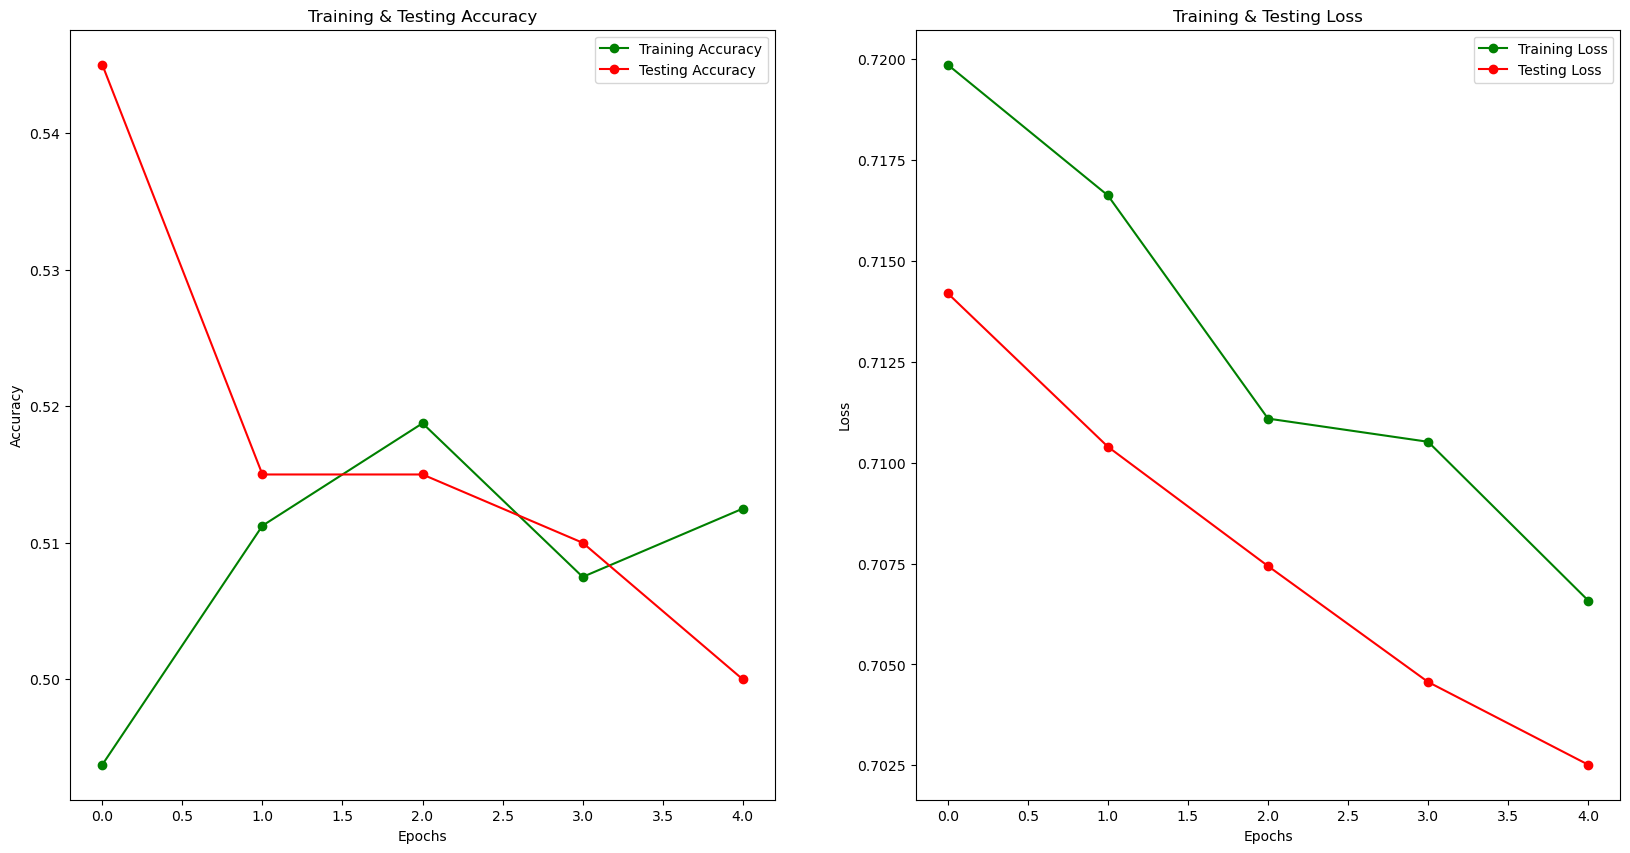

In [266]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs, 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , test_accs, 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , test_losses , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [267]:
print(f'train_accs: {train_accs}')
print(f'test_accs: {test_accs}')
print(f'train_losses: {train_losses}')
print(f'test_losses: {test_losses}')

train_accs: [0.49375, 0.51125, 0.51875, 0.5075, 0.5125]
test_accs: [0.545, 0.515, 0.515, 0.51, 0.5]
train_losses: [0.7198594298958778, 0.716620683670044, 0.7110910177230835, 0.7105159091949463, 0.706581757068634]
test_losses: [0.7141954946517944, 0.7103931903839111, 0.7074368929862976, 0.7045637202262879, 0.7025142621994018]


Text(95.72222222222221, 0.5, 'Actual')

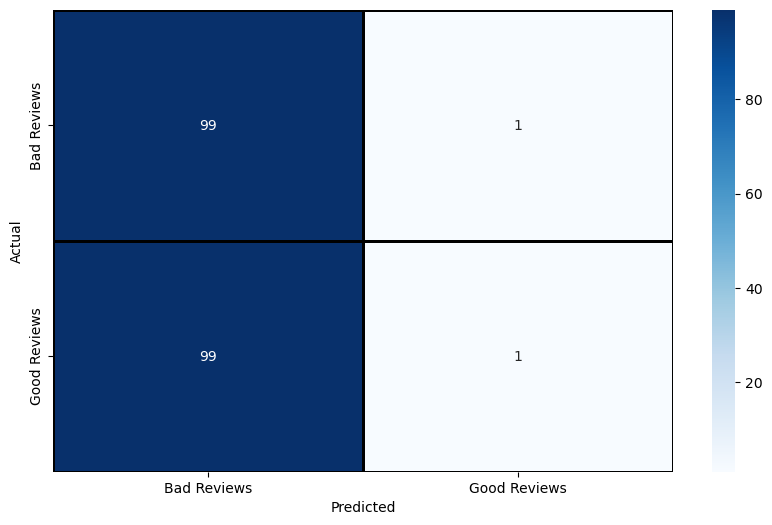

In [268]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize = (10,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")